In [1]:
import numpy as np
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.risk as risk
import mlgrad.avragg as avragg
# import mlgrad.gd as gd
import mlgrad.regnorm as regnorm
import mlgrad.weights as weights
from mlgrad.utils import array_exclude_outliers

import mlgrad.regr as regr

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk, mrisk

#import sklearn.linear_model as sklm

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-ticks'])

import sys
print(sys.version)

3.9.2 (default, Feb 28 2021, 17:03:44) 
[GCC 10.2.1 20210110]


In [2]:
df = pd.read_csv("data/starsCYG.csv", sep=',', usecols=["log.Te", "log.light"], )

In [3]:
len(df)

47

In [4]:
df

,log.Te,log.light
0,4.37,5.23
1,4.56,5.74
2,4.26,4.93
3,4.56,5.74
4,4.30,5.19
5,4.46,5.46
6,3.84,4.65
7,4.57,5.27
8,4.26,5.57
9,4.37,5.12


In [5]:
Y = df["log.light"].values
X = df["log.Te"].values

X -= np.median(X)
Y -= np.median(Y)

# x_min, x_max = X.min(), X.max()
# X = (X - x_min) / (x_max - x_min)
# y_min, y_max = Y.min(), Y.max()
# Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

X0 = np.linspace(X.min(), X.max(), 20)

In [6]:
from sklearn.preprocessing import scale

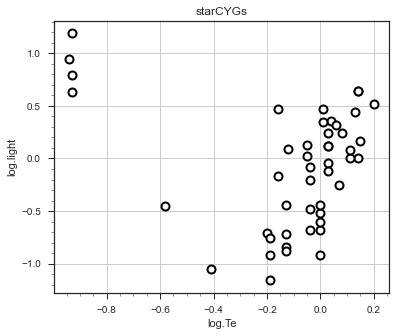

In [7]:
plt.figure(figsize=(6.0, 5.0))
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=2.)
plt.title('starCYGs')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
# plt.xlim(-0.9, 0.6)
# plt.ylim(-2.5, 2.0)
plt.show()

In [8]:
loss_func_sq = loss.ErrorLoss(func.Square())
# loss_func_rsq = loss.RelativeErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())

In [9]:
sqr_norm = regnorm.SquareNorm()

In [10]:
def curve_fit_and_errors(alg):
    err = np.abs(Y - alg.risk.model.evaluate_all(Xs))
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.title('Fit curve')
    plt.plot(alg.lvals)
    plt.xlabel('step')
    plt.ylabel('mean of errors')
    plt.minorticks_on()
    plt.subplot(1,2,2)
    plt.title('Errors')
    plt.plot(sorted(err), marker='s', markersize='6')
    plt.minorticks_on()
    plt.xlabel('error rank')
    plt.ylabel('error value')
    plt.show()
    return err

In [11]:
mod_ls = model.LinearModel(1)
mod_ls.init()

[0.78839469 0.66718546] 2


K=1500 param=[-0.09260396 -0.36405901]


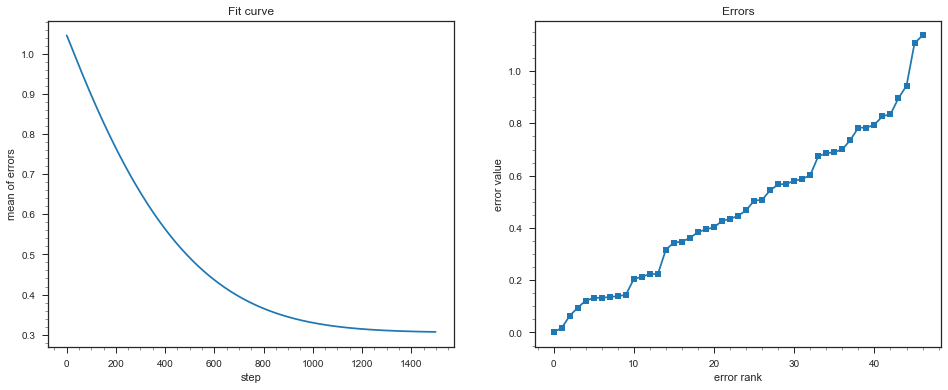

In [12]:
alg_ls = regr.regression(Xs, Y, mod_ls, n_iter=1500, verbose=1)
err_ls = curve_fit_and_errors(alg_ls)

In [13]:
mod_m_irls = model.LinearModel(1)
mod_m_irls.init()

[0.51624921 0.71753695] 2


K=70 param=[-0.31615331  2.49333401]


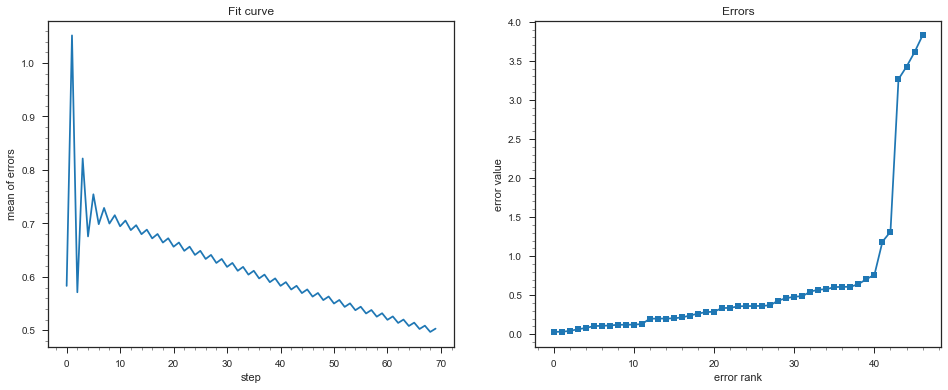

In [14]:
avg_m_irls = regr.averaging_function('M', rhofunc=func.Quantile_Sqrt(0.84, 0.001))
alg_m_irls = regr.m_regression_irls(Xs, Y, mod_m_irls, avrfunc=avg_m_irls, h=0.001, n_iter2=70, verbose=1)
err_m_irls = curve_fit_and_errors(alg_m_irls)

In [15]:
mod_wm_irls = model.LinearModel(1)
mod_wm_irls.init()

[0.32444958 0.42737165] 2


K=70 param=[-0.16744895  2.19316176]


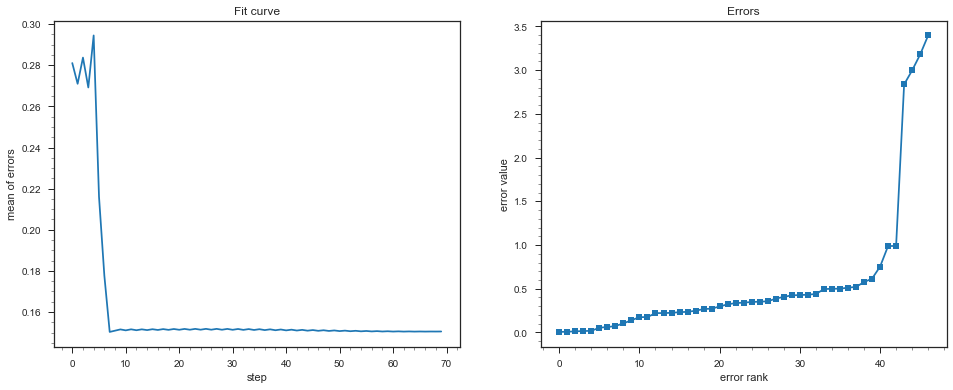

In [16]:
avg_wm_irls = regr.averaging_function('WM', rhofunc=func.Sqrt(0.001), alpha=0.84)
alg_wm_irls = regr.m_regression_irls(Xs, Y, mod_wm_irls, avrfunc=avg_wm_irls, h=0.001, n_iter2=70, verbose=1)
err_wm_irls = curve_fit_and_errors(alg_wm_irls)

In [17]:
mod_swm_irls = model.LinearModel(1)
mod_swm_irls.init()

[0.12227095 0.58242096] 2


K=21 param=[-0.19376697  2.9301483 ]


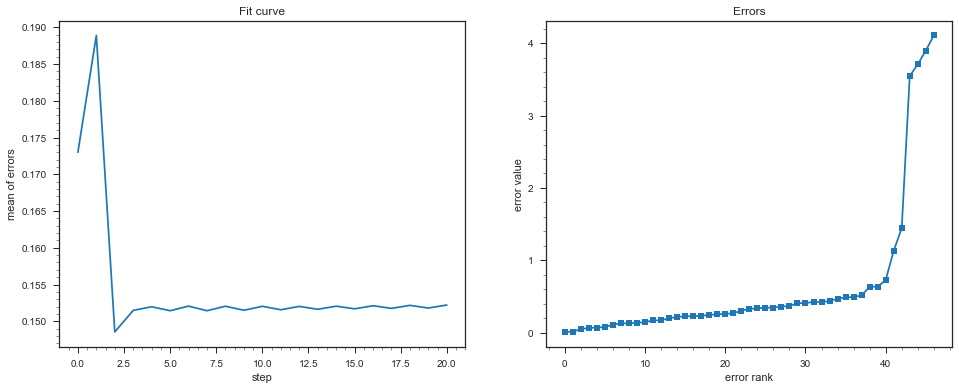

In [18]:
avg_swm_irls = regr.averaging_function('SWM', rhofunc=func.Sqrt(0.001), alpha=0.84)
alg_swm_irls = regr.m_regression_irls(Xs, Y, mod_swm_irls, avrfunc=avg_swm_irls, h=0.001, tol=1.0e-8, verbose=1)
err_swm_irls = curve_fit_and_errors(alg_swm_irls)

In [19]:
# Err = np.abs(Y - mod2.evaluate_all(Xs))

# X1, X1_ = array_exclude_outliers(X, Err, 7) 
# Y1, Y1_ = array_exclude_outliers(Y, Err, 7) 
# X1s = X1.reshape(-1,1)

In [20]:
mod_r_irls = model.LinearModel(1)
mod_r_irls.init()

[0.31936757 0.60950706] 2


K=3 param=[0.20601806 1.13106525]


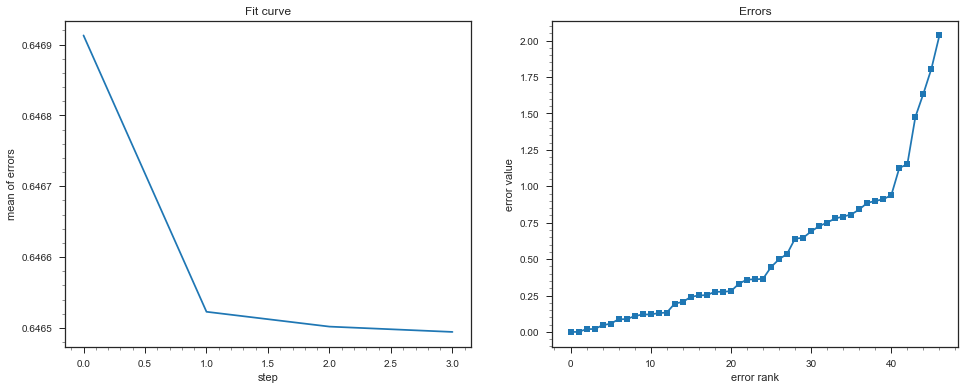

In [21]:
alg_r_irls = regr.r_regression_irls(Xs, Y, mod_r_irls, rhofunc=func.Sqrt(0.001), verbose=1)
err_r_irls = curve_fit_and_errors(alg_r_irls)

In [23]:
# mod_wm_ls = model.LinearModel(1)
# mod_wm_ls.init()

In [24]:
# avg_wm_ls = regr.averaging_function('WM', rhofunc=func.Quantile_Sqrt(0.84, 0.001))
# alg_wm_ls = regr.m_regression(Xs, Y, mod_wm_ls, avrfunc=avg_wm_ls, h=0.1, tol=1.0e-8)
# err_wm_ls = curve_fit_and_errors(alg_wm_ls)

In [25]:
# mod_hm_irls = model.LinearModel(1)
# mod_hm_irls.init()

In [26]:
# avg_hm_irls = regr.averaging_function('HM', rhofunc=func.Quantile_Sqrt(0.85, 0.001))
# alg_hm_irls = regr.m_regression_irls(Xs, Y, mod_hm_irls, avrfunc=avg_hm_irls, h=0.001, tol=1.0e-9, n_iter2=22, tol2=1.0e-8)
# err_hm_irls = curve_fit_and_errors(alg_hm_irls)

[-0.34027438  0.2164538  -0.6625907   0.2164538  -0.54538476 -0.07656104
 -1.89325298  0.24575528 -0.6625907  -0.34027438 -2.91880489 -0.16446548
 -0.01795807 -1.39512777 -0.57468625 -0.19376697 -0.75049514 -0.19376697
 -0.75049514 -2.91880489 -0.57468625 -0.57468625 -0.19376697  0.01134341
 -0.3109729  -0.19376697 -0.57468625 -0.3109729  -0.77979663 -2.94810637
 -0.3109729   0.2164538  -0.10586252 -2.91880489 -0.75049514  0.39226269
  0.12854935 -0.10586252  0.12854935 -0.16446548 -0.3109729  -0.10586252
  0.0406449  -0.10586252  0.18715231 -0.10586252 -0.19376697]


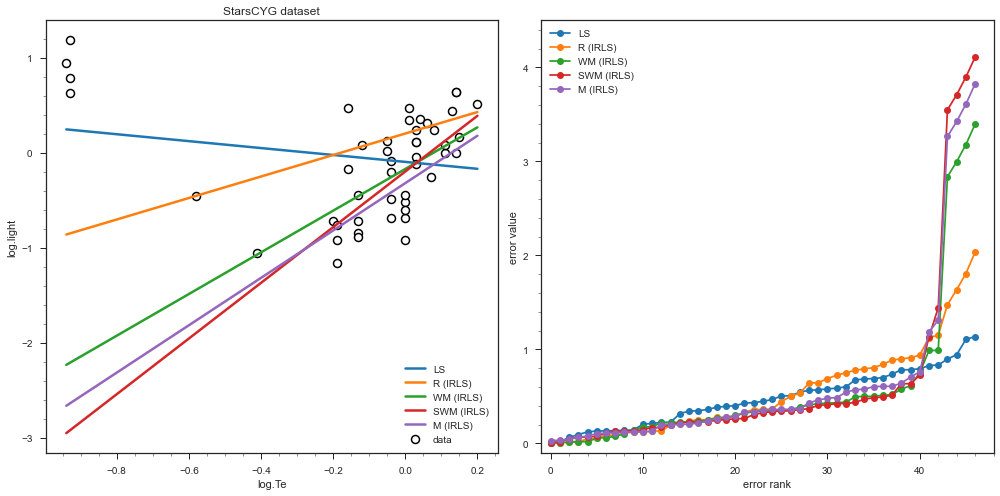

In [27]:
plt.figure(figsize=(14.0, 7.0))
plt.subplot(1,2,1)
plt.title('StarsCYG dataset')
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=1.5, label='data')
plt.plot(X0, mod_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'LS')
plt.plot(X0, mod_r_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'R (IRLS)')
plt.plot(X0, mod_wm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (IRLS)')
# plt.plot(X0, mod_wm_ls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'WM (LS)')
plt.plot(X0, mod_swm_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'SWM (IRLS)')
plt.plot(X0, mod_m_irls.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'M (IRLS)')
print(mod_swm_irls.evaluate_all(Xs))
plt.minorticks_on()
# plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(sorted(np.abs(Y - mod_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'LS')
plt.plot(sorted(np.abs(Y - mod_r_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'R (IRLS)')
plt.plot(sorted(np.abs(Y - mod_wm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (IRLS)')
# plt.plot(sorted(np.abs(Y - mod_wm_ls.evaluate_all(Xs))), marker='o', markersize=7, label=r'WM (LS)')
plt.plot(sorted(np.abs(Y - mod_swm_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'SWM (IRLS)')
plt.plot(sorted(np.abs(Y - mod_m_irls.evaluate_all(Xs))), marker='o', markersize=7, label=r'M (IRLS)')
plt.minorticks_on()
# plt.grid(1)
plt.ylabel('error value')
plt.xlabel('error rank')
plt.ylim(-0.1, 4.5)
plt.xlim(-1, 48)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [28]:
41/47

0.8723404255319149